# Chevron Track Rice Datathon 2025

Objective: Predicting Vehicle Inventory for 2025

Steps:

 A. Feature Selection / Data Cleaning

B.Data Splitting / Pre-Processing

C. Model Training and Testing

D. Model Evaluation - Assess models using 
    metrics such as accuracy, precision, recall and F1 score

Data Dictionary

- Date: The year of the inventory

- Vehicle Category: The category of the vehicle

- GVWR Class: Gross Vehicle Weight Rating

- Fuel Type: The type of fuel (gas, electric, diesel)

- Model Year: Model Year of the vehicle

- Fuel Technology (ICE, Hybrid, Electric)

- Electric Mileage: How far the vehicle travels on a single charge

- Number of Vehicles Registered at the Same Address: How many vehicles are registered at the same address.

- Region: How the count is aggregated (i.e. for the entire state / or by zip code)

- Vehicle Population: The total vehicle population

In [74]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
import os

#Importing the classes for data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Import machine learning algorithms
from sklearn.linear_model import LinearRegression  # Linear regression model
from sklearn.ensemble import RandomForestClassifier  # Ensemble method for classification
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.naive_bayes import GaussianNB  # Naive Bayes classifier
from lightgbm import LGBMRegressor  # LightGBM regression model

# Import validation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split  # For splitting dataset
from sklearn.metrics import mean_squared_error, r2_score  # Regression evaluation metrics
from sklearn.metrics import RocCurveDisplay

# Set display options for pandas
pd.set_option('display.max_columns', None)


training = pd.read_excel('training.xlsx')
scoring = pd.read_excel("scoring.xlsx")


In [75]:
#Setting a Random Seed here for reproduceability
random.seed(27)
np.random.seed(27)

import warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)

In [76]:
#Display the shape of the training dataset
training.shape

(41053, 10)

In [77]:
#Display the shape of the scoring dataset
scoring.shape

(7546, 10)

In [78]:
#Rename the Features to make them more readable
training = training.rename(columns={
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    'Model Year': 'modelYear',
    'Fuel Technology': 'fuelTechnology',
    'Electric Mile Range': 'electricMileRange',
    'Number of Vehicles Registered at the Same Address': 'numVehiclesReg',
    'Vehicle Population:': 'vehiclePopulation'
})


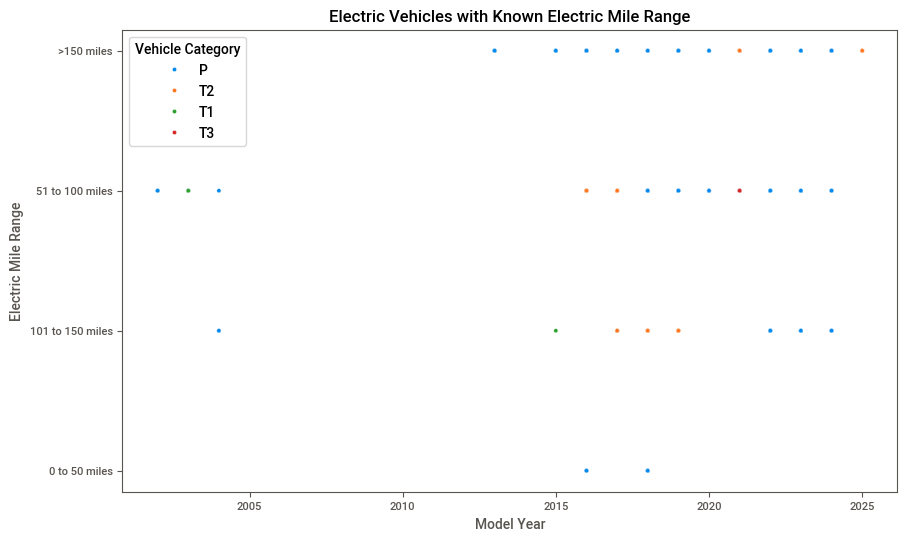

In [79]:
# Filter the dataset
electric_vehicles = training[(training['fuelType'] == 'Electric') & 
                             (training['electricMileRange'] != 'Unknown') & 
                             (training['electricMileRange'] != 'Not Applicable')]

# Plot the filtered dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=electric_vehicles, x='modelYear', y='electricMileRange', hue='vehicleCategory')
plt.xlabel('Model Year')
plt.ylabel('Electric Mile Range')
plt.title('Electric Vehicles with Known Electric Mile Range')
plt.legend(title='Vehicle Category')
plt.show()

#### Data Cleaning / Exploratory Data Analysis

Add comment here

In [80]:
#Take a look at the outliers in our dataset.

#Using the mean as our dataset does not contain that many outliers etc.

In [81]:
# fill missing values with the mean of our modelYear column
training['modelYear'].fillna(training['modelYear'].mean(), inplace=True)

In [82]:
#Dropping the Region column
training = training.drop(columns=['Region'])

In [83]:
training["gvwrClassKN"] = training["gvwrClass"].apply(lambda x:  1 if x == "Unknown" else 0)
training["gvwrClass"] = training["gvwrClass"].replace("Unknown", -1)
training["gvwrClass"] = training["gvwrClass"].replace("Not Applicable", 0)

#Our GVWR Column, 
#Not applicable = 0
#Unkown isss?
#So add a column where gvwr type included (binary)

In [84]:
print(training["gvwrClass"].apply(type).value_counts())

gvwrClass
<class 'int'>    41053
Name: count, dtype: int64


We will be using One-Hot Encoding on the categorical features like, fuelType, electricMileRange, numVehiclesReg, because it will enable us to use these features in our machine learning models later on. This is important since most machine learning models require numerical inputs. One-hot encoding helps us avoid introducing ordinal relationships that might arise from numerically encoding categorical variables, which could mislead the model into thinking there's an inherent order. The one-hot encoder will create new columns for each unique category and convert the values into binary vectors, allowing us to then input them into our ML models.

electricMileRange, we are going to later on OneHotEncode this column

fuelType, we are going to later on OneHotEncode this column

numVehiclesReg, we are going to later on OneHotEncode this column

In [85]:
#An option, if this doesn't give us the results we want, we can OneHotEncode this instead
training

,Date,vehicleCategory,gvwrClass,fuelType,modelYear,fuelTechnology,electricMileRange,numVehiclesReg,Vehicle Population,gvwrClassKN
0,2019,P,0,Gasoline,2020.0,ICE,Not Applicable,≥4,395883,0
1,2020,P,0,Gasoline,2020.0,ICE,Not Applicable,1,370954,0
2,2021,P,0,Gasoline,2020.0,ICE,Not Applicable,1,349406,0
3,2019,P,0,Gasoline,2019.0,ICE,Not Applicable,≥4,348475,0
4,2019,P,0,Gasoline,2018.0,ICE,Not Applicable,≥4,333296,0
...,...,...,...,...,...,...,...,...,...,...
41048,2019,B,0,Diesel,1983.0,ICE,Not Applicable,1,1,0
41049,2019,B,0,Diesel,1980.0,ICE,Not Applicable,2,1,0
41050,2019,B,0,Diesel,1978.0,ICE,Not Applicable,3,1,0
41051,2019,B,0,Diesel,1976.0,ICE,Not Applicable,2,1,0


In [86]:
training["numVehiclesReg"] = training["numVehiclesReg"].apply(lambda x:  4 if x == "≥4" else x)
training["numVehiclesRegKN"] = training["numVehiclesReg"].apply(lambda x:  1 if x == "Unknown" else 0)
training["numVehiclesReg"] = training["numVehiclesReg"].replace("Unknown", -1)
training

,Date,vehicleCategory,gvwrClass,fuelType,modelYear,fuelTechnology,electricMileRange,numVehiclesReg,Vehicle Population,gvwrClassKN,numVehiclesRegKN
0,2019,P,0,Gasoline,2020.0,ICE,Not Applicable,4,395883,0,0
1,2020,P,0,Gasoline,2020.0,ICE,Not Applicable,1,370954,0,0
2,2021,P,0,Gasoline,2020.0,ICE,Not Applicable,1,349406,0,0
3,2019,P,0,Gasoline,2019.0,ICE,Not Applicable,4,348475,0,0
4,2019,P,0,Gasoline,2018.0,ICE,Not Applicable,4,333296,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,B,0,Diesel,1983.0,ICE,Not Applicable,1,1,0,0
41049,2019,B,0,Diesel,1980.0,ICE,Not Applicable,2,1,0,0
41050,2019,B,0,Diesel,1978.0,ICE,Not Applicable,3,1,0,0
41051,2019,B,0,Diesel,1976.0,ICE,Not Applicable,2,1,0,0


In [87]:
print(training.dtypes)


Date                    int64
vehicleCategory        object
gvwrClass               int64
fuelType               object
modelYear             float64
fuelTechnology         object
electricMileRange      object
numVehiclesReg          int64
Vehicle Population      int64
gvwrClassKN             int64
numVehiclesRegKN        int64
dtype: object


In [88]:
print(training['vehicleCategory'].apply(type).value_counts())

vehicleCategory
<class 'str'>    41053
Name: count, dtype: int64


In [89]:
print(training['gvwrClass'].apply(type).value_counts())

gvwrClass
<class 'int'>    41053
Name: count, dtype: int64


In [90]:
print(training['fuelType'].apply(type).value_counts())

fuelType
<class 'str'>    41053
Name: count, dtype: int64


In [91]:
print(training['modelYear'].apply(type).value_counts())

modelYear
<class 'float'>    41053
Name: count, dtype: int64


In [92]:
print(training['numVehiclesReg'].apply(type).value_counts())

numVehiclesReg
<class 'int'>    41053
Name: count, dtype: int64


In [93]:
print(training.isnull().sum())    

Date                  0
vehicleCategory       0
gvwrClass             0
fuelType              0
modelYear             0
fuelTechnology        0
electricMileRange     0
numVehiclesReg        0
Vehicle Population    0
gvwrClassKN           0
numVehiclesRegKN      0
dtype: int64


In [94]:
#Get the initial statistics of the training dataset
training.describe()

,Date,gvwrClass,modelYear,numVehiclesReg,Vehicle Population,gvwrClassKN,numVehiclesRegKN
count,41053.000000,41053.000000,41053.000000,41053.000000,41053.000000,41053.000000,41053.000000
mean,2020.985312,1.524615,2002.075871,2.559983,3463.929506,0.213431,0.000804
std,1.398470,2.694434,13.363417,1.160483,18833.839302,0.409735,0.028341
min,2019.000000,-1.000000,1975.000000,-1.000000,1.000000,0.000000,0.000000
25%,2020.000000,0.000000,1991.000000,1.000000,5.000000,0.000000,0.000000
50%,2021.000000,0.000000,2003.000000,3.000000,39.000000,0.000000,0.000000
75%,2022.000000,3.000000,2014.000000,4.000000,390.000000,0.000000,0.000000
max,2023.000000,8.000000,2026.000000,4.000000,395883.000000,1.000000,1.000000


In [108]:
training['gvwrClass'].describe()

count    41053.000000
mean         1.524615
std          2.694434
min         -1.000000
25%          0.000000
50%          0.000000
75%          3.000000
max          8.000000
Name: gvwrClass, dtype: float64

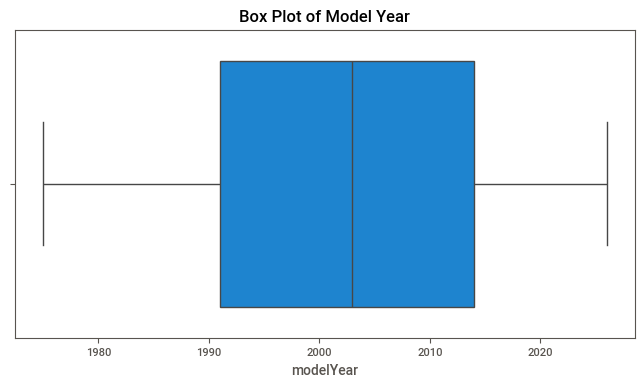

In [95]:
#Take a look a the distribution of model year
plt.figure(figsize=(8, 4))
sns.boxplot(x=training['modelYear'])
plt.title("Box Plot of Model Year")
plt.show()

A Kernel Density Estimate (KDE) plot is a smooth representation of the data's distribution.

The peak of the curve, represents the value with the highest likelhood of occuring.

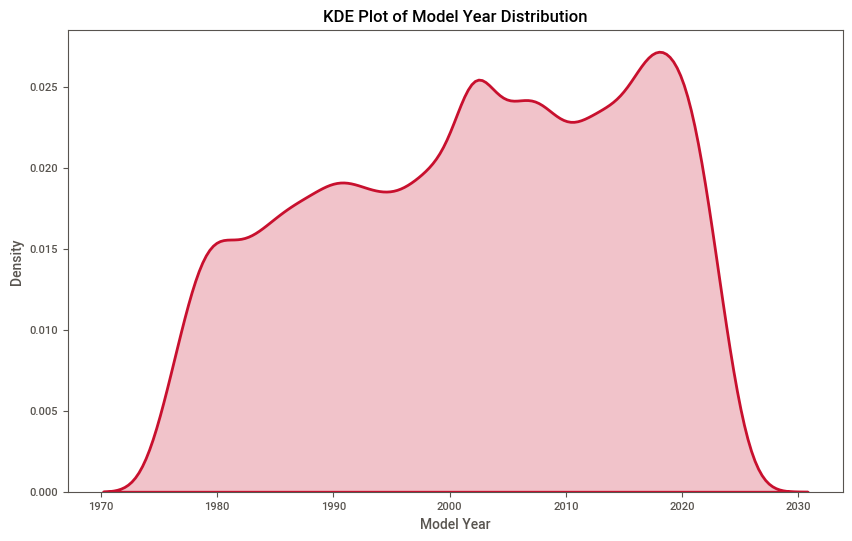

In [96]:
plt.figure(figsize=(10, 6))
sns.kdeplot(training['modelYear'], fill=True, color="#C8102E", linewidth=2)
plt.xlabel("Model Year")
plt.ylabel("Density")
plt.title("KDE Plot of Model Year Distribution")
plt.show()

Our KDE plot reveals a wide distribution, suggesting that the data does not have a concentration of vehicles from a single model year. Notably, the plot shows an increasing skew toward newer model years. This is expected, as vehicles tend to have a finite lifespan; over time, they are more likely to be involved in accidents, experience significant mechanical failures, or wear out, which could shorten their lifespan.

In [97]:
#Variance of ModelYear
print(training['modelYear'].var())

178.58092542462015


The high variance here suggests there is a significant diversity in the model years as supported by the KDE Plot and Box Plot above.

Visualizing the Missing Values (none) after cleaning the dataset to validate the steps above.

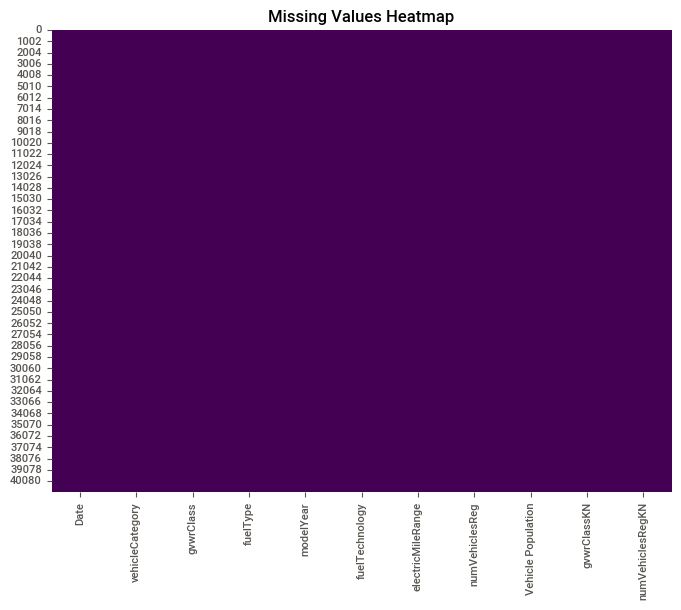

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(training.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [99]:
training

,Date,vehicleCategory,gvwrClass,fuelType,modelYear,fuelTechnology,electricMileRange,numVehiclesReg,Vehicle Population,gvwrClassKN,numVehiclesRegKN
0,2019,P,0,Gasoline,2020.0,ICE,Not Applicable,4,395883,0,0
1,2020,P,0,Gasoline,2020.0,ICE,Not Applicable,1,370954,0,0
2,2021,P,0,Gasoline,2020.0,ICE,Not Applicable,1,349406,0,0
3,2019,P,0,Gasoline,2019.0,ICE,Not Applicable,4,348475,0,0
4,2019,P,0,Gasoline,2018.0,ICE,Not Applicable,4,333296,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,B,0,Diesel,1983.0,ICE,Not Applicable,1,1,0,0
41049,2019,B,0,Diesel,1980.0,ICE,Not Applicable,2,1,0,0
41050,2019,B,0,Diesel,1978.0,ICE,Not Applicable,3,1,0,0
41051,2019,B,0,Diesel,1976.0,ICE,Not Applicable,2,1,0,0


In [100]:
import pygwalker as pyg

In [101]:
pyg.walk(training)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062d18808d8d6cOhbVrpoi6gR1IfLB" style="height: auto">\n    <hea…

In [102]:


X = training.drop(columns=['Vehicle Population'])
y = training['Vehicle Population']

from flaml import AutoML

# Initialize AutoML
automl = AutoML()

# Define FLAML settings. Adjust time_budget (in seconds) and metric as needed.
automl_settings = {
    "time_budget": 60,            # total running time in seconds (adjust based on your dataset)
    "metric": 'rmse',             # metric for regression; for classification you might use 'accuracy' or another metric
    "task": 'regression',         # specify the task type: 'regression' or 'classification'
    "log_file_name": "flaml.log", # optional: log file to save training logs
}

# Fit AutoML on the training data
automl.fit(X_train=X, y_train=y, **automl_settings)


[flaml.automl.logger: 02-01 12:05:23] {1728} INFO - task = regression
[flaml.automl.logger: 02-01 12:05:23] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-01 12:05:23] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 02-01 12:05:23] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 02-01 12:05:23] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-01 12:05:23] {2393} INFO - Estimated sufficient time budget=1122s. Estimated necessary time budget=8s.
[flaml.automl.logger: 02-01 12:05:23] {2442} INFO -  at 0.4s,	estimator lgbm's best error=17220.6663,	best estimator lgbm's best error=17220.6663
[flaml.automl.logger: 02-01 12:05:23] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-01 12:05:23] {2442} INFO -  at 0.6s,	estimator lgbm's best error=17220.6663,	best estimator lgbm's best error=17220.6663
[flaml.automl.logger: 02-

In [103]:
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparameter config:", automl.best_config)
print("Best performance achieved during tuning:", automl.best_loss)



Best ML leaner: rf
Best hyperparameter config: {'n_estimators': 161, 'max_features': 1.0, 'max_leaves': 18229}
Best performance achieved during tuning: 3698.8356410839215


In [104]:
predictions = automl.predict(X)
